## VLSA Walkthrough

This notebook provides you the detail of 
- individual **incidence function prediction** in VLSA models;
- and the **prediction interpretation** (reproducing Figure 2, the left one) using our Shapley values-based method.

In [1]:
import os
import os.path as osp
os.chdir("../")
os.getcwd()

'/home/liup/repo/VLSA'

Specify the path to
- the VLSA model trained on `BLCA` training samples (see `./assert/blca-train-VLSA`)
- the patch features of a WSI sample (extracted by `CONCH`; stored in `./assert/blca-test-WSI-TCGA-XF-A9ST.pth`)

In [2]:
CUDA_ID = 0
run_path = "./assert/blca-train-VLSA" # the VLSA model fitted on BLCA training samples
path_wsi = "./assert/blca-test-WSI-TCGA-XF-A9ST.pt" # wsi patch features

### Load the model and the test sample

Here we load 
- the patch features of the WSI sample
- the VLSA model, consisting of 
  - the visual and textual encoders of `CONCH` (please download it from [huggingface](https://huggingface.co/MahmoodLab/CONCH) and place it at `{path_clip_model}/mahmoodlab/conch`; `{path_clip_model}` shown be specified in `./assert/blca-train-VLSA/config.yaml`.)
  - the trained parameters of `VLSA` (provided in `./assert/blca-train-VLSA`; yes, it is only with a few learnable parameters).

In [3]:
from utils.model_inference import load_vlsa_model
from utils.io import read_patch_data

# load patch features 
wsi_feats = read_patch_data(path_wsi, dtype='torch')
print("\nLoaded the patch features of one WSI: {} x {}.\n".format(wsi_feats.shape[0], wsi_feats.shape[1]))

# load model
model, cfg = load_vlsa_model(run_path, CUDA_ID, return_cfg=True)

[SurvIFMLE] initialized a SurvIFMLE loss with reduction = mean.
[SurvIFMLE] initialized a SurvIFMLE loss with reduction = mean.

Loaded the patch features of one WSI: 2798 x 512.

[Model CFG] loaded config from ./assert/blca-train-VLSA/config.yaml
[VLSA-UNI] Found additional kwargs: {'vlsa_api': 'CONCH', 'path_clip_model': '/NAS02/Others/pretrained-models'}.
[Tokenizer] CONCH Tokenizer runs with built-in functions.
[VL model loading] Building VL model with CONCH API...
[VL model loading] Text backbone : mahmoodlab/conch.


/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[VL model loading] MIL backbone: VLFAN
[LVFAN] got Text for query_type; please call `reset_query` later to reset it.
[LVFAN] nn.Linear is used in the end projection.
[VLFAN] warning: use a simple Cross-Attention Layer.
[VL model loading] Try VLFAN with arguments: {'dim_hid': 256, 'dim_in': 512, 'dim_reduction': 4, 'drop_rate': 0.25, 'frozen': False, 'gated_query': False, 'keep_ratio': 0.8, 'name': 'VLFAN', 'num_query': 12, 'pred_head': 'default', 'query': 'Text', 'query_pooling': 'mean', 'query_text_dim_reduction': 4, 'query_text_keep_ratio': 0.8, 'query_text_load_idx': 'tcga_blca_0', 'query_text_load_path': 'tools/survival_text_prototypes.json', 'query_text_method': 'TaskRes', 'query_text_res_ratio': 0.5, 'use_feat_proj': False}.
[RankPromptLearner] Found irrelevant kwargs: {'ckpt': None, 'frozen_context_embeds': False, 'frozen_rank_embeds': False, 'method': 'rank', 'name': 'CoOp', 'pretrained': False}.
[RankPromptLearner] loaded initial context (a histopathology image suggesting) and

In [4]:
import torch

X = wsi_feats.to(next(model.parameters()).device)

# load essential variables (logit_scale) from the VLSA model
model.eval()
with torch.no_grad():
    logit_scale = model.get_logit_scale()

logit_scale = logit_scale.detach().item()
coattn_logit_scale = model.mil_encoder.get_coattn_logit_scale().item() # with exp

### Get visual features and textual prompt features

calculate textual prompt features

In [5]:
import torch.nn.functional as F

with torch.no_grad():
    text_features = model.forward_text_only()
    norm_text_features = F.normalize(text_features, dim=-1) # [num_ranks, emb_dim]

text_features = text_features.detach()
norm_text_features = norm_text_features.detach()
print("Textual prompt features: {} x {}".format(text_features.shape[0], text_features.shape[1]))
print("\tthe number of textual prompts: {}".format(text_features.shape[0]))
print("\tthe dim of textual prompt features: {}".format(text_features.shape[1]))

Textual prompt features: 12 x 512
	the number of textual prompts: 12
	the dim of textual prompt features: 512


Next, we 
- calculate visual features (i.e., WSI-level visual representation)
- and measure the similarity between visual features and a group of textual prompt features.

In [6]:
with torch.no_grad():
    # Approach 1 = a direct way = model's forward process 
    X = X.unsqueeze(0) # [1, N, d]
    # here we use language-encoded prognostic priors as queries in cross-attention to learn WSI-level representation
    image_feature, cottn_score = model.mil_encoder(X, ret_with_attn=True) 
    L_image_feature = image_feature.norm(dim=-1) # [1, emb_dim]
    norm_image_feature = image_feature / L_image_feature # [1, emb_dim]
    img_txt_similarities = norm_image_feature @ norm_text_features.t() # [1, num_ranks]
    probs = F.softmax(logit_scale * img_txt_similarities, dim=-1) # [1, num_ranks], the predicted incidence function

probs = probs.detach().cpu()
print("Predicted incidence function (model forword pass):", probs)

Predicted incidence function (model forword pass): tensor([[0.4904, 0.2488, 0.1200, 0.0419, 0.0143, 0.0079, 0.0047, 0.0031, 0.0038,
         0.0071, 0.0167, 0.0412]])


### Plot individual incidence function prediction

visualize the predicted IF (incident function) and survival function

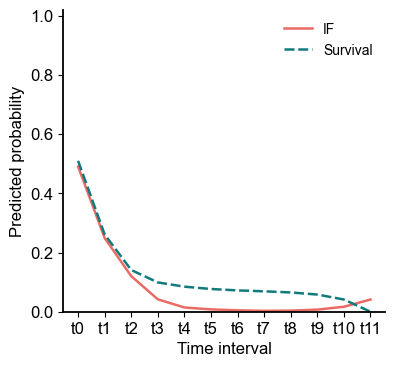

In [7]:
from utils.visualization import get_survival_plot

survival_plot = get_survival_plot(probs)
survival_plot.set_dpi(100)
survival_plot.patch.set_facecolor('white')
display(survival_plot)

### Interpreting the prediction of VLSA (shown in Figure 2, the left one in the paper)

Our interpretation approach is based on [**Shapley values**](https://en.wikipedia.org/wiki/Shapley_value). Specifically, we
- first calculate the vision-language similarity **decoupled along the query dimension in cross-attention**;
- and then use it to calculate the Shapley values of **the introduced language-encoded priors**.

In [8]:
from utils.model_inference import evaluate_prototype_shap_imp

with torch.no_grad():
    # Approach 2 = a decoupled way, which leads to the same result as Approach 1
    enc_X = model.mil_encoder.visual_adapter(X) # [1, N, d]
    norm_enc_X = enc_X.squeeze(0) / L_image_feature # [N, d]
    cottn_score = cottn_score.squeeze(0) # [P, N]
    decoupled_img_txt_similarities = cottn_score @ (norm_enc_X @ norm_text_features.t()) # [P, N] @ [N, num_ranks] -> [P, num_ranks]
    probs_2 = F.softmax(logit_scale * decoupled_img_txt_similarities.mean(dim=0, keepdims=True), dim=-1) # [1, num_ranks]

probs_2 = probs_2.detach().cpu()
print("Predicted incidence function (decoupled forword pass):", probs_2)
decoupled_img_txt_similarities = decoupled_img_txt_similarities.detach().cpu()
decoupled_shap_imp = evaluate_prototype_shap_imp(decoupled_img_txt_similarities, logit_scale)
print(f"[SHAP] Risk = Base + SHAP: {1+decoupled_shap_imp.sum().item()} = {1} + {decoupled_shap_imp.sum().item()}.")
print("[SHAP] SHAP values (contribution to risk) over prototypes:")
print("\t{}".format(decoupled_shap_imp))

Predicted incidence function (decoupled forword pass): tensor([[0.4904, 0.2488, 0.1200, 0.0418, 0.0143, 0.0079, 0.0047, 0.0031, 0.0038,
         0.0071, 0.0167, 0.0412]])
[SHAP] Risk = Base + SHAP: 10.523673057556152 = 1 + 9.523673057556152.
[SHAP] SHAP values (contribution to risk) over prototypes:
	tensor([ 1.2516,  1.5317,  1.0909,  1.0213,  0.0532,  1.1087,  0.4945,  0.5926,
        -0.4723,  0.2201,  1.3658,  1.2655])


### Plot each prior's contribution to overall risk (reproducing Figure 2, left one)

The prognostic language priors used for BLCA (also provided in `./tools/survival_text_prototypes.json`) are as follows:
- P1: 'Abnormalities in the size, shape, and organization of tumor cells. High degrees of atypia are associated with more aggressive tumors.'
- P2: 'Variation in the size and shape of the nuclei within tumor cells. Pronounced pleomorphism typically indicates a higher grade and more aggressive cancer.'
- P3: 'The presence and frequency of cell division figures (mitoses) within the tumor. High mitotic activity suggests rapid tumor growth and a poorer prognosis.'
- P4: 'The structural arrangement of the tumor, such as solid or mixed patterns.'
- P5: 'Tumor cells invade deep into the bladder wall layers, especially into detrusor muscle or muscularis propria, perivesical fat and beyond.'
- P6: 'Tumor cells within blood vessels or lymphatic channels.'
- P7: 'Areas of dead (necrotic) tumor cells within the tissue. Necrosis often appears as regions lacking viable cells and can indicate rapid tumor growth outpacing its blood supply.'
- P8: 'Tumor cells surrounding or invading nerves.'
- P9: 'Dense fibrous or connective tissue growth around the tumor indicates an aggressive response to the tumor, often seen in high-grade cancers.'
- P10: 'Tumor cells penetrate the surrounding stroma, muscle, or other tissues, lack of a clear demarcation between the tumor and the normal tissue, known as poorly defined tumor margins.'
- P11: 'Formation of new blood vessels within the tumor, necessary for tumor growth and spread. High levels of angiogenesis indicate a more aggressive tumor.'
- P12: 'Presence of areas of flat, high-grade, non-invasive cancer, known as carcinoma in situ, identified by high-grade cellular atypia, disorganized epithelial structure, increased and atypical mitotic activity, loss of normal epithelial architecture, and absence of umbrella cells.'

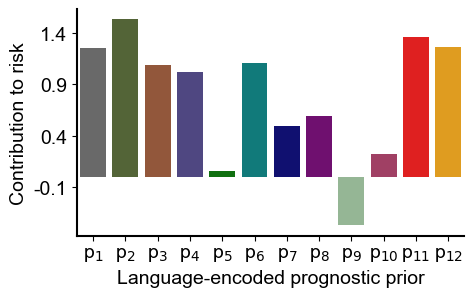

In [9]:
from utils.visualization import get_mixture_plot

# Visualization codes are partially adapted from PANTHER
imp_plot = get_mixture_plot(decoupled_shap_imp, ticks_step=0.5)
imp_plot.set_dpi(100)
imp_plot.patch.set_facecolor('white')
display(imp_plot)